In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [17]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Dataset

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


torch.Size([64, 1, 28, 28])
torch.Size([64])


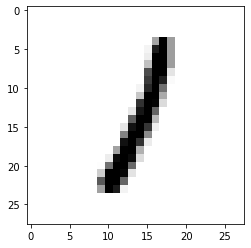

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

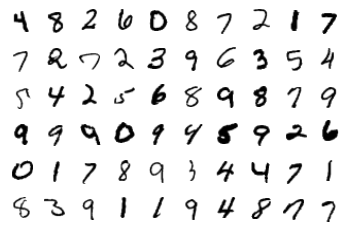

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Construct the neuron network

### Structure

In [9]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


### Loss function

In [38]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [11]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0027, -0.0027, -0.0027,  ..., -0.0027, -0.0027, -0.0027],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        ...,
        [-0.0001, -0.0001, -0.0001,  ..., -0.0001, -0.0001, -0.0001],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017],
        [ 0.0050,  0.0050,  0.0050,  ...,  0.0050,  0.0050,  0.0050]])


### Training

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
        print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6494274639022122

Training Time (in minutes) = 0.10202208360036215
Epoch 1 - Training loss: 0.2826024048618162

Training Time (in minutes) = 0.19753379821777345
Epoch 2 - Training loss: 0.21590932051160697

Training Time (in minutes) = 0.2922056476275126
Epoch 3 - Training loss: 0.1734427979696534

Training Time (in minutes) = 0.3872969150543213
Epoch 4 - Training loss: 0.14518530198585378

Training Time (in minutes) = 0.48283108075459796
Epoch 5 - Training loss: 0.12475111548389707

Training Time (in minutes) = 0.5780080954233805
Epoch 6 - Training loss: 0.11042299924164152

Training Time (in minutes) = 0.6724885940551758
Epoch 7 - Training loss: 0.09847906309722075

Training Time (in minutes) = 0.7683069984118144
Epoch 8 - Training loss: 0.08915320357907491

Training Time (in minutes) = 0.8662331978480021
Epoch 9 - Training loss: 0.0796768065881548

Training Time (in minutes) = 0.9707062125205994
Epoch 10 - Training loss: 0.07266333171559661

Training Time 

### Testing and Evaluation

Predicted Digit = 8


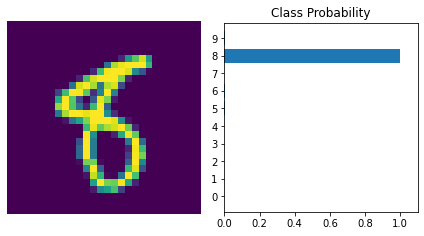

In [47]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [19]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9725


### Try VGG Structure

In [ ]:
## VGG structure with full-connected-layer
